In [1270]:
#All imports here
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


#### This notebook borrows ideas and some code snippets  from : https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner
#### https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml and https://www.kaggle.com/code/hrideshkohli/advanced-feature-selection-analysis-classification in order to choose the initial features .
#### Proper Feature selection and Dimensionality Reduction flow is followed to filter out and select the final features.
#### This notebook only serves as a proof of work and a convenient way to access the feature flow and shouldn't be used for classification tasks directly.
#### The relevant code is in data_loader/data.py .Doctstrings of the methods explain the relevant usage.

In [1271]:
for dirname, _, filenames in os.walk('./kaggle/input'): # User agnostic
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/goalscorers.csv
./kaggle/input/archive (3).zip
./kaggle/input/.DS_Store
./kaggle/input/2022_world_cup_groups.csv
./kaggle/input/world_cup_matches.csv
./kaggle/input/World Cup 2018 Dataset.csv
./kaggle/input/2022_world_cup_matches.csv
./kaggle/input/shootouts.csv
./kaggle/input/fifa_ranking-2023-07-20.csv
./kaggle/input/data_dictionary.csv
./kaggle/input/archive.zip
./kaggle/input/fifa_ranking.csv
./kaggle/input/international_matches.csv
./kaggle/input/results.csv
./kaggle/input/fifa_ranking 2.csv
./kaggle/input/world_cups.csv


## DATA CLEANING AND ORGANIZATION

In [1272]:
# Datasets
#1870s football data
historic_matches = pd.read_csv('./kaggle/input/results.csv')
#45100 matches
#Fifa Rankinf Data
fifa_rank = pd.read_csv('./kaggle/input/fifa_ranking-2023-07-20.csv')
#That is all I need .The rest of the files are in this folder and should be accessed if they are needed..

# Let's drop all games before 1990 (fifa rank data.You have 28k matches now)
historic_matches["date"] = pd.to_datetime(historic_matches["date"]) #Fixing non-sense dates
fifa_rank["rank_date"] = pd.to_datetime(fifa_rank["rank_date"]) #Fixing non-sense dates
historic_matches = historic_matches[(historic_matches["date"] >= "1990-1-1")].reset_index(drop=True)
historic_matches.shape
#28619 matches




(28916, 9)

In [1273]:
# match 
historic_matches.head(5)

date home_team  away_team  home_score  away_score tournament  \
0 1990-01-12   Algeria       Mali           5           0   Friendly   
1 1990-01-14   Algeria   Cameroon           3           1   Friendly   
2 1990-01-17    Greece    Belgium           2           0   Friendly   
3 1990-01-17    Mexico  Argentina           2           0   Friendly   
4 1990-01-20    Malawi   Tanzania           2           2   Friendly   

          city        country  neutral  
0        Paris         France     True  
1        Paris         France     True  
2       Athens         Greece    False  
3  Los Angeles  United States     True  
4      Lobamba       Eswatini     True

In [1274]:
fifa_rank.shape

(64757, 8)

In [1275]:
#fifa_rank
fifa_rank.tail(5)

rank       country_full country_abrv  total_points  previous_points  \
64752    66         Cabo Verde          CPV       1354.65          1354.65   
64753    67            Iceland          ISL       1352.98          1352.98   
64754    68    North Macedonia          MKD       1350.53          1350.53   
64755    58            Jamaica          JAM       1409.73          1367.83   
64756   205  US Virgin Islands          VIR        816.59           816.59   

       rank_change confederation  rank_date  
64752            0           CAF 2023-07-20  
64753            0          UEFA 2023-07-20  
64754            0          UEFA 2023-07-20  
64755           -5      CONCACAF 2023-07-20  
64756           -3      CONCACAF 2023-07-20

In [1276]:
#bad data count
#matches
historic_matches.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [1277]:
#Ranks
fifa_rank.isna().sum()

rank               0
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [1278]:
#Latest values in your dataset
historic_matches.sort_values("date").tail()

date             home_team    away_team  home_score  away_score  \
28883 2023-10-17             Sri Lanka        Yemen           1           1   
28884 2023-10-17                Taiwan  Timor-Leste           3           0   
28886 2023-10-17                Angola     DR Congo           0           0   
28874 2023-10-17               Uruguay       Brazil           2           0   
28915 2023-10-23  United Arab Emirates       Kuwait           1           0   

                         tournament        city               country  neutral  
28883  FIFA World Cup qualification     Colombo             Sri Lanka    False  
28884  FIFA World Cup qualification   Kaohsiung                Taiwan    False  
28886                      Friendly     Setúbal              Portugal     True  
28874  FIFA World Cup qualification  Montevideo               Uruguay    False  
28915                      Friendly       Dubai  United Arab Emirates    False

In [1279]:
#Latest values in your dataset
fifa_rank.sort_values("rank_date").tail()

rank       country_full country_abrv  total_points  previous_points  \
64621   194         Seychelles          SEY        856.71           860.13   
64622   195            Eritrea          ERI        855.56           855.56   
64623   196            Somalia          SOM        854.72           854.72   
64651   161      New Caledonia          NCL        995.58           995.58   
64756   205  US Virgin Islands          VIR        816.59           816.59   

       rank_change confederation  rank_date  
64621           -2           CAF 2023-07-20  
64622           -3           CAF 2023-07-20  
64623           -3           CAF 2023-07-20  
64651            0           OFC 2023-07-20  
64756           -3      CONCACAF 2023-07-20

In [1280]:
#Let's start pasting this data
#Before that name fixes for countries that might have changed names since the 90s or might have multiple names so that we can track
fifa_rank["country_full"] = fifa_rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
# We first add two kinds of columns one for home_team and one for away_team 
fifa_rank = fifa_rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
historic_matches_ranked = historic_matches.merge(fifa_rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

historic_matches_ranked = historic_matches_ranked.merge(fifa_rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [1281]:
fifa_rank.tail(5)
fifa_rank.to_csv("Fifa_Grouped_Ranking.csv",index = False)

In [1282]:
historic_matches_ranked[(historic_matches_ranked.home_team == "Germany") | (historic_matches_ranked.away_team == "Germany")].tail(10)

date   home_team away_team  home_score  away_score  \
22688 2022-09-26     England   Germany           3           3   
22763 2022-11-16        Oman   Germany           0           1   
22829 2022-11-23     Germany     Japan           1           2   
22846 2022-11-27       Spain   Germany           1           1   
22862 2022-12-01  Costa Rica   Germany           2           4   
22985 2023-03-25     Germany      Peru           2           0   
23042 2023-03-28     Germany   Belgium           2           3   
23084 2023-06-12     Germany   Ukraine           3           3   
23111 2023-06-16      Poland   Germany           1           0   
23171 2023-06-20     Germany  Colombia           0           2   

                tournament           city  country  neutral  \
22688  UEFA Nations League         London  England    False   
22763             Friendly         Muscat     Oman    False   
22829       FIFA World Cup      Al Rayyan    Qatar     True   
22846       FIFA World Cup        Al Khor    Qatar     True   
22862       FIFA World Cup        Al Khor    Qatar     True   
22985             Friendly          Mainz  Germany    False   
23042             Friendly        Cologne  Germany    False   
23084             Friendly         Bremen  Germany    False   
23111             Friendly         Warsaw   Poland    False   
23171             Friendly  Gelsenkirchen  Germany    False   

       total_points_home  previous_points_home  rank_home  rank_change_home  \
22688            1737.46               1737.46        5.0               0.0   
22763            1320.29               1323.03       75.0               0.0   
22829            1650.21               1658.96       11.0               0.0   
22846            1715.22               1716.93        7.0               1.0   
22862            1503.59               1500.06       31.0              -3.0   
22985            1646.91               1650.21       14.0               3.0   
23042            1646.91               1650.21       14.0               3.0   
23084            1647.42               1646.91       14.0               0.0   
23111            1553.76               1559.83       23.0               1.0   
23171            1647.42               1646.91       14.0               0.0   

       total_points_away  previous_points_away  rank_away  rank_change_away  
22688            1658.96               1658.96       11.0               0.0  
22763            1650.21               1658.96       11.0               0.0  
22829            1559.54               1554.69       24.0               0.0  
22846            1650.21               1658.96       11.0               0.0  
22862            1650.21               1658.96       11.0               0.0  
22985            1564.30               1561.01       21.0              -2.0  
23042            1781.30               1816.71        4.0               2.0  
23084            1530.04               1536.99       30.0               4.0  
23111            1647.42               1646.91       14.0               0.0  
23171            1617.08               1612.78       17.0               0.0

In [1283]:
historic_matches_ranked.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away'],
      dtype='object')

In [1284]:
#TODO: If folks require this change this later . 
#Tournament coded as friendly/non_friendly ( 0 and 1)
historic_matches_ranked["tournament"] = historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
historic_matches_ranked["neutral"] = historic_matches_ranked.apply(lambda row : 0 if (row.neutral == "True") else 1 ,axis=1)
historic_matches_ranked[(historic_matches_ranked.home_team == "Germany") | (historic_matches_ranked.away_team == "Germany")].tail(10)


date   home_team away_team  home_score  away_score  tournament  \
22688 2022-09-26     England   Germany           3           3           1   
22763 2022-11-16        Oman   Germany           0           1           0   
22829 2022-11-23     Germany     Japan           1           2           1   
22846 2022-11-27       Spain   Germany           1           1           1   
22862 2022-12-01  Costa Rica   Germany           2           4           1   
22985 2023-03-25     Germany      Peru           2           0           0   
23042 2023-03-28     Germany   Belgium           2           3           0   
23084 2023-06-12     Germany   Ukraine           3           3           0   
23111 2023-06-16      Poland   Germany           1           0           0   
23171 2023-06-20     Germany  Colombia           0           2           0   

                city  country  neutral  total_points_home  \
22688         London  England        1            1737.46   
22763         Muscat     Oman        1            1320.29   
22829      Al Rayyan    Qatar        1            1650.21   
22846        Al Khor    Qatar        1            1715.22   
22862        Al Khor    Qatar        1            1503.59   
22985          Mainz  Germany        1            1646.91   
23042        Cologne  Germany        1            1646.91   
23084         Bremen  Germany        1            1647.42   
23111         Warsaw   Poland        1            1553.76   
23171  Gelsenkirchen  Germany        1            1647.42   

       previous_points_home  rank_home  rank_change_home  total_points_away  \
22688               1737.46        5.0               0.0            1658.96   
22763               1323.03       75.0               0.0            1650.21   
22829               1658.96       11.0               0.0            1559.54   
22846               1716.93        7.0               1.0            1650.21   
22862               1500.06       31.0              -3.0            1650.21   
22985               1650.21       14.0               3.0            1564.30   
23042               1650.21       14.0               3.0            1781.30   
23084               1646.91       14.0               0.0            1530.04   
23111               1559.83       23.0               1.0            1647.42   
23171               1646.91       14.0               0.0            1617.08   

       previous_points_away  rank_away  rank_change_away  
22688               1658.96       11.0               0.0  
22763               1658.96       11.0               0.0  
22829               1554.69       24.0               0.0  
22846               1658.96       11.0               0.0  
22862               1658.96       11.0               0.0  
22985               1561.01       21.0              -2.0  
23042               1816.71        4.0               2.0  
23084               1536.99       30.0               4.0  
23111               1646.91       14.0               0.0  
23171               1612.78       17.0               0.0

In [1285]:
historic_matches_ranked.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away'],
      dtype='object')

In [1286]:
# Pad one-hot-coded match outcome
#First goal difference
historic_matches_ranked['GoalDifference'] = historic_matches_ranked.apply(lambda row: row.home_score - row.away_score,axis=1)
historic_matches_ranked['Target_Outcome_Win'] = historic_matches_ranked.apply(lambda row : 1 if (row.GoalDifference > 0) else 0 ,axis=1)
historic_matches_ranked['Target_Outcome_Loss'] = historic_matches_ranked.apply(lambda row : 1 if (row.GoalDifference < 0) else 0 ,axis=1)
historic_matches_ranked['Target_Outcome_Tie'] = historic_matches_ranked.apply(lambda row : 1 if (row.GoalDifference == 0) else 0 ,axis=1)
historic_matches_ranked[(historic_matches_ranked.home_team == "Germany") | (historic_matches_ranked.away_team == "Germany")].tail(10)

date   home_team away_team  home_score  away_score  tournament  \
22688 2022-09-26     England   Germany           3           3           1   
22763 2022-11-16        Oman   Germany           0           1           0   
22829 2022-11-23     Germany     Japan           1           2           1   
22846 2022-11-27       Spain   Germany           1           1           1   
22862 2022-12-01  Costa Rica   Germany           2           4           1   
22985 2023-03-25     Germany      Peru           2           0           0   
23042 2023-03-28     Germany   Belgium           2           3           0   
23084 2023-06-12     Germany   Ukraine           3           3           0   
23111 2023-06-16      Poland   Germany           1           0           0   
23171 2023-06-20     Germany  Colombia           0           2           0   

                city  country  neutral  total_points_home  ...  rank_home  \
22688         London  England        1            1737.46  ...        5.0   
22763         Muscat     Oman        1            1320.29  ...       75.0   
22829      Al Rayyan    Qatar        1            1650.21  ...       11.0   
22846        Al Khor    Qatar        1            1715.22  ...        7.0   
22862        Al Khor    Qatar        1            1503.59  ...       31.0   
22985          Mainz  Germany        1            1646.91  ...       14.0   
23042        Cologne  Germany        1            1646.91  ...       14.0   
23084         Bremen  Germany        1            1647.42  ...       14.0   
23111         Warsaw   Poland        1            1553.76  ...       23.0   
23171  Gelsenkirchen  Germany        1            1647.42  ...       14.0   

       rank_change_home  total_points_away  previous_points_away  rank_away  \
22688               0.0            1658.96               1658.96       11.0   
22763               0.0            1650.21               1658.96       11.0   
22829               0.0            1559.54               1554.69       24.0   
22846               1.0            1650.21               1658.96       11.0   
22862              -3.0            1650.21               1658.96       11.0   
22985               3.0            1564.30               1561.01       21.0   
23042               3.0            1781.30               1816.71        4.0   
23084               0.0            1530.04               1536.99       30.0   
23111               1.0            1647.42               1646.91       14.0   
23171               0.0            1617.08               1612.78       17.0   

       rank_change_away  GoalDifference  Target_Outcome_Win  \
22688               0.0               0                   0   
22763               0.0              -1                   0   
22829               0.0              -1                   0   
22846               0.0               0                   0   
22862               0.0              -2                   0   
22985              -2.0               2                   1   
23042               2.0              -1                   0   
23084               4.0               0                   0   
23111               0.0               1                   1   
23171               0.0              -2                   0   

       Target_Outcome_Loss  Target_Outcome_Tie  
22688                    0                   1  
22763                    1                   0  
22829                    1                   0  
22846                    0                   1  
22862                    1                   0  
22985                    0                   0  
23042                    1                   0  
23084                    0                   1  
23111                    0                   0  
23171                    1                   0  

[10 rows x 21 columns]

In [1287]:
#Shape 
historic_matches_ranked.shape
# 9 features


(23227, 21)

# PRELIMINARY HYPOTHESIS TESTING

In [1288]:
#plt.figure(figsize=(15, 10))
#sns.heatmap(historic_matches_ranked[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
#plt.show()
# CORRELATION MATRIX PRESENT
historic_matches_ranked[["total_points_home", "rank_home", "total_points_away", "rank_away","previous_points_home","previous_points_away","rank_change_home","rank_change_away","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

total_points_home  rank_home  total_points_away  \
total_points_home              1.000000  -0.421091           0.826692   
rank_home                     -0.421091   1.000000          -0.178574   
total_points_away              0.826692  -0.178574           1.000000   
rank_away                     -0.157320   0.489348          -0.403767   
previous_points_home           0.997530  -0.416774           0.825440   
previous_points_away           0.826549  -0.177618           0.997148   
rank_change_home              -0.010516   0.036422           0.001116   
rank_change_away               0.023726  -0.011704           0.009079   
Target_Outcome_Win             0.081229  -0.180472          -0.130969   
Target_Outcome_Loss           -0.080391   0.207124           0.124008   
Target_Outcome_Tie            -0.010650  -0.006268           0.023060   

                      rank_away  previous_points_home  previous_points_away  \
total_points_home     -0.157320              0.997530              0.826549   
rank_home              0.489348             -0.416774             -0.177618   
total_points_away     -0.403767              0.825440              0.997148   
rank_away              1.000000             -0.154834             -0.398698   
previous_points_home  -0.154834              1.000000              0.827501   
previous_points_away  -0.398698              0.827501              1.000000   
rank_change_home       0.009141              0.028561              0.003750   
rank_change_away       0.022139              0.026694              0.050788   
Target_Outcome_Win     0.246570              0.081722             -0.129759   
Target_Outcome_Loss   -0.197116             -0.080691              0.122278   
Target_Outcome_Tie    -0.081568             -0.010912              0.023460   

                      rank_change_home  rank_change_away  Target_Outcome_Win  \
total_points_home            -0.010516          0.023726            0.081229   
rank_home                     0.036422         -0.011704           -0.180472   
total_points_away             0.001116          0.009079           -0.130969   
rank_away                     0.009141          0.022139            0.246570   
previous_points_home          0.028561          0.026694            0.081722   
previous_points_away          0.003750          0.050788           -0.129759   
rank_change_home              1.000000          0.046494            0.006052   
rank_change_away              0.046494          1.000000           -0.010873   
Target_Outcome_Win            0.006052         -0.010873            1.000000   
Target_Outcome_Loss          -0.000373         -0.002623           -0.598753   
Target_Outcome_Tie           -0.006689          0.015474           -0.541462   

                      Target_Outcome_Loss  Target_Outcome_Tie  
total_points_home               -0.080391           -0.010650  
rank_home                        0.207124           -0.006268  
total_points_away                0.124008            0.023060  
rank_away                       -0.197116           -0.081568  
previous_points_home            -0.080691           -0.010912  
previous_points_away             0.122278            0.023460  
rank_change_home                -0.000373           -0.006689  
rank_change_away                -0.002623            0.015474  
Target_Outcome_Win              -0.598753           -0.541462  
Target_Outcome_Loss              1.000000           -0.349163  
Target_Outcome_Tie              -0.349163            1.000000

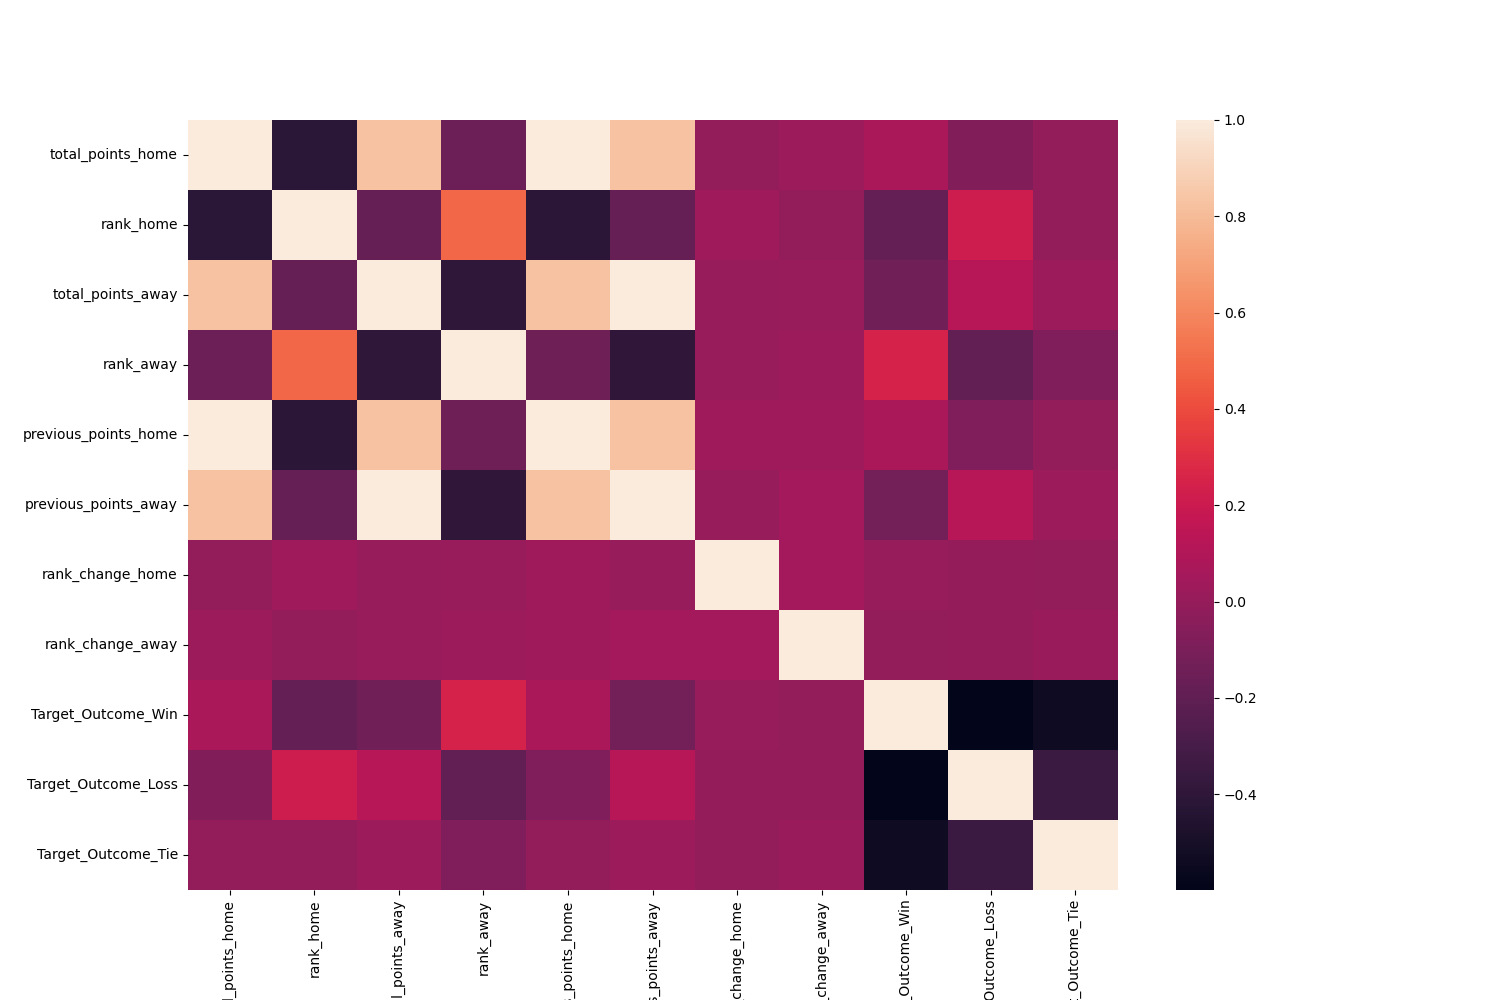

In [1289]:
#HEat map
plt.figure(figsize=(15, 10))
sns.heatmap(historic_matches_ranked[["total_points_home", "rank_home", "total_points_away", "rank_away","previous_points_home","previous_points_away","rank_change_home","rank_change_away","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr())
plt.show()

In [1290]:
#Drop the redundant features (Extremely high correlation among themselves) with poor correlation to output
# points home ,away (present/previous),rank change(poor correlation)
historic_matches_ranked[[ "rank_home", "rank_away","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

rank_home  rank_away  Target_Outcome_Win  \
rank_home             1.000000   0.489348           -0.180472   
rank_away             0.489348   1.000000            0.246570   
Target_Outcome_Win   -0.180472   0.246570            1.000000   
Target_Outcome_Loss   0.207124  -0.197116           -0.598753   
Target_Outcome_Tie   -0.006268  -0.081568           -0.541462   

                     Target_Outcome_Loss  Target_Outcome_Tie  
rank_home                       0.207124           -0.006268  
rank_away                      -0.197116           -0.081568  
Target_Outcome_Win             -0.598753           -0.541462  
Target_Outcome_Loss             1.000000           -0.349163  
Target_Outcome_Tie             -0.349163            1.000000

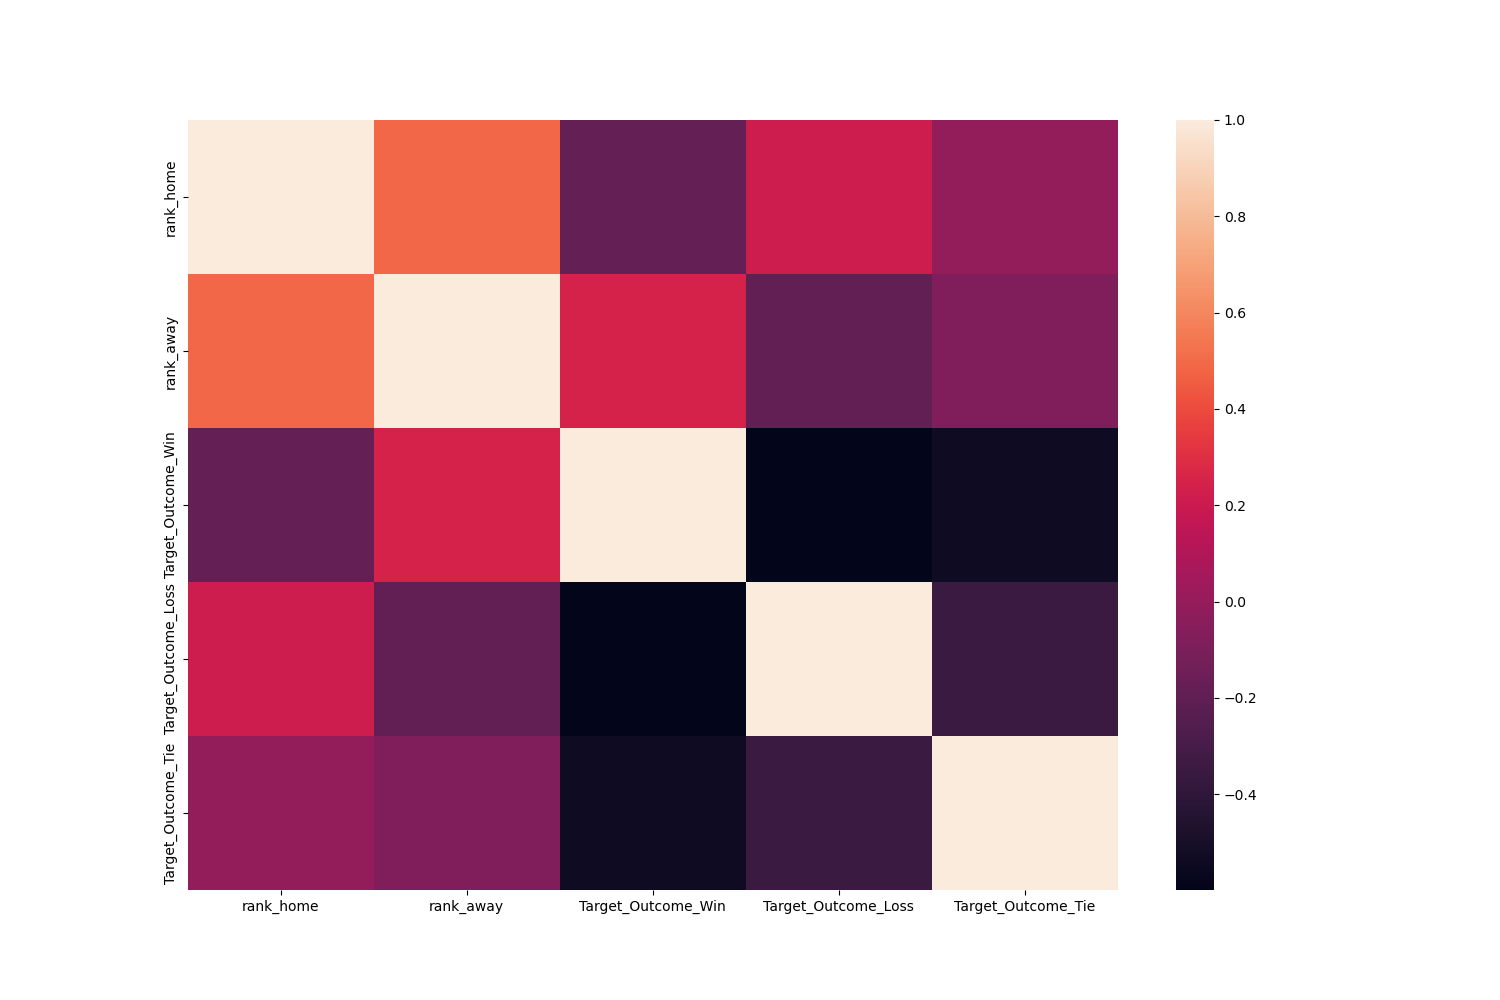

In [1291]:
plt.figure(figsize=(15, 10))
sns.heatmap(historic_matches_ranked[[ "rank_home", "rank_away","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson'))
plt.show()

In [1292]:
historic_matches_ranked["del_rank"] = historic_matches_ranked["rank_home"] - historic_matches_ranked["rank_away"]
historic_matches_ranked[[ "rank_home", "rank_away","del_rank","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')
#Rank_difference is a better indicator already!

rank_home  rank_away  del_rank  Target_Outcome_Win  \
rank_home             1.000000   0.489348  0.495226           -0.180472   
rank_away             0.489348   1.000000 -0.515302            0.246570   
del_rank              0.495226  -0.515302  1.000000           -0.422981   
Target_Outcome_Win   -0.180472   0.246570 -0.422981            1.000000   
Target_Outcome_Loss   0.207124  -0.197116  0.399907           -0.598753   
Target_Outcome_Tie   -0.006268  -0.081568  0.075097           -0.541462   

                     Target_Outcome_Loss  Target_Outcome_Tie  
rank_home                       0.207124           -0.006268  
rank_away                      -0.197116           -0.081568  
del_rank                        0.399907            0.075097  
Target_Outcome_Win             -0.598753           -0.541462  
Target_Outcome_Loss             1.000000           -0.349163  
Target_Outcome_Tie             -0.349163            1.000000

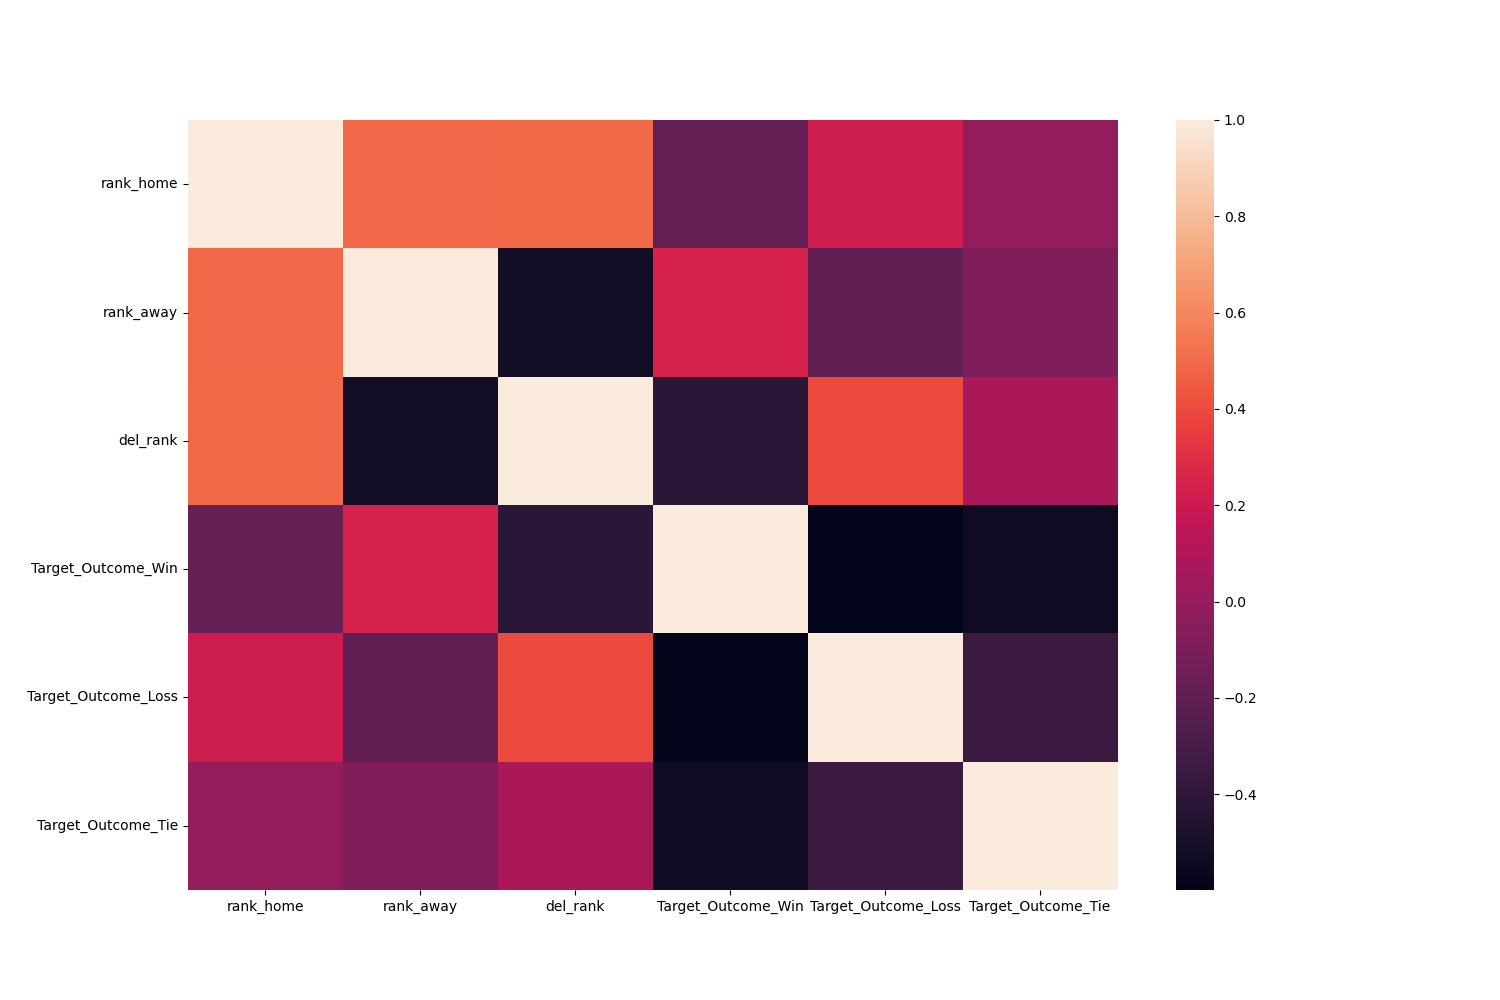

In [1293]:
plt.figure(figsize=(15, 10))
sns.heatmap(historic_matches_ranked[[ "rank_home", "rank_away","del_rank","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson'))
plt.show()

# SOME VISUALIZATIONS

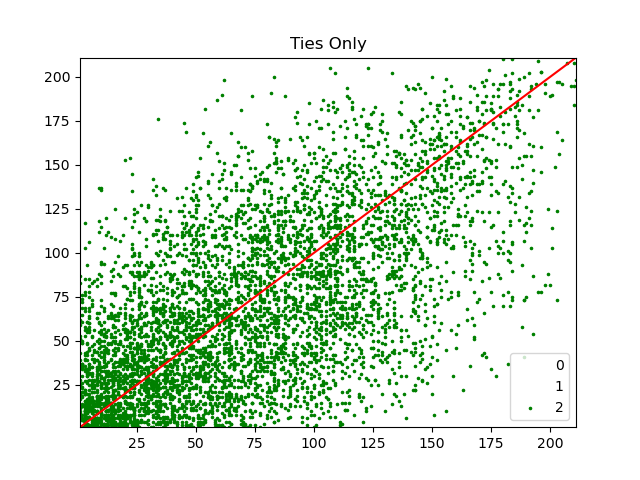

In [1294]:
rankA = historic_matches_ranked["rank_home"]
rankA = rankA.to_numpy()
rankB = historic_matches_ranked["rank_away"]
rankB = rankB.to_numpy()
outcomes = historic_matches_ranked[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final"] = historic_matches_ranked.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
outcomes_r = outcomes["final"]
outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
cdict = {1:'white',0:'white',2:'green'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Ties Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

In [1295]:
outcomes.head(5)

Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  final
0                   0                    0                   1      2
1                   0                    0                   1      2
2                   1                    0                   0      1
3                   0                    1                   0      0
4                   1                    0                   0      1

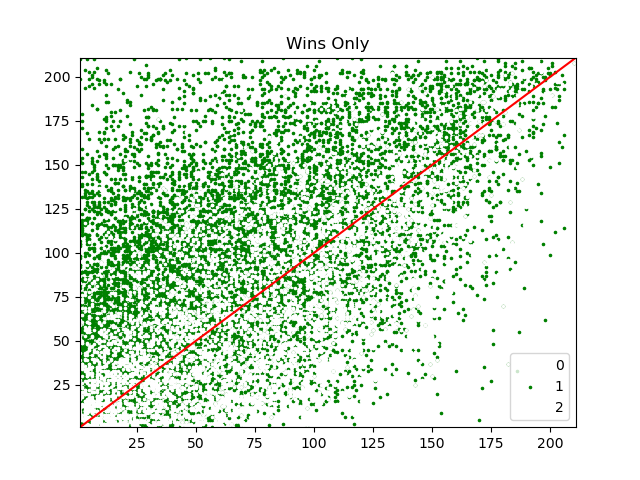

In [1296]:
cdict = {1:'green',0:'white',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Wins Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

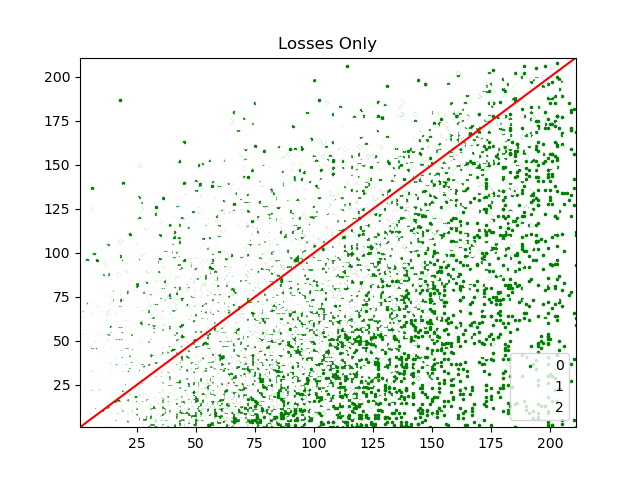

In [1297]:
cdict = {1:'white',0:'green',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Losses Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

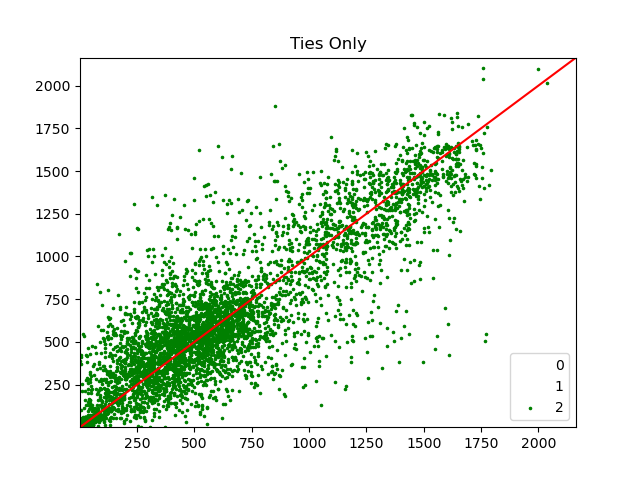

In [1298]:
rankA = historic_matches_ranked["total_points_home"]
rankA = rankA.to_numpy()
rankB = historic_matches_ranked["total_points_away"]
rankB = rankB.to_numpy()
outcomes = historic_matches_ranked[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final"] = historic_matches_ranked.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
outcomes_r = outcomes["final"]
outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
cdict = {1:'white',0:'white',2:'green'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Ties Only")
plt.show()
#fig = plt.figure()

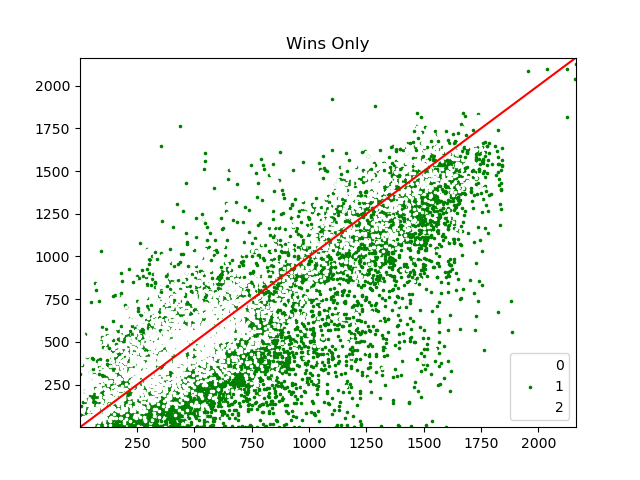

In [1299]:
cdict = {1:'green',0:'white',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Wins Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

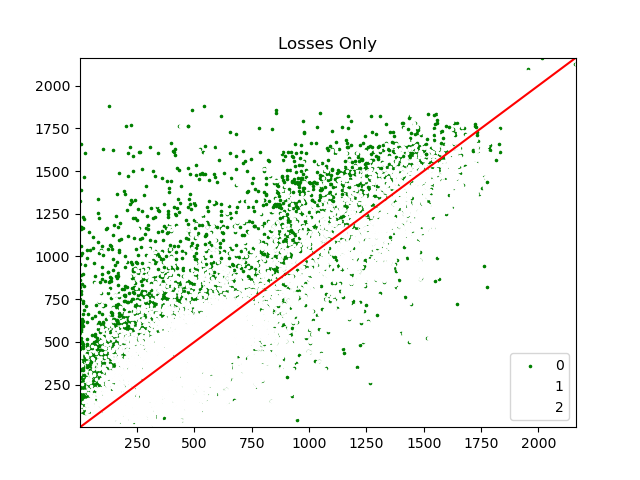

In [1300]:
cdict = {1:'white',0:'green',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Losses Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

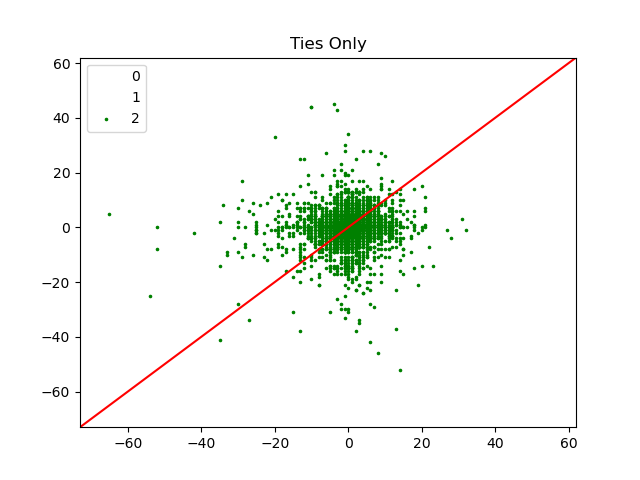

In [1301]:
rankA = historic_matches_ranked["rank_change_home"]
rankA = rankA.to_numpy()
rankB = historic_matches_ranked["rank_change_away"]
rankB = rankB.to_numpy()
outcomes = historic_matches_ranked[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final"] = historic_matches_ranked.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
outcomes_r = outcomes["final"]
outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
cdict = {1:'white',0:'white',2:'green'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Ties Only")
plt.show()
#fig = plt.figure()

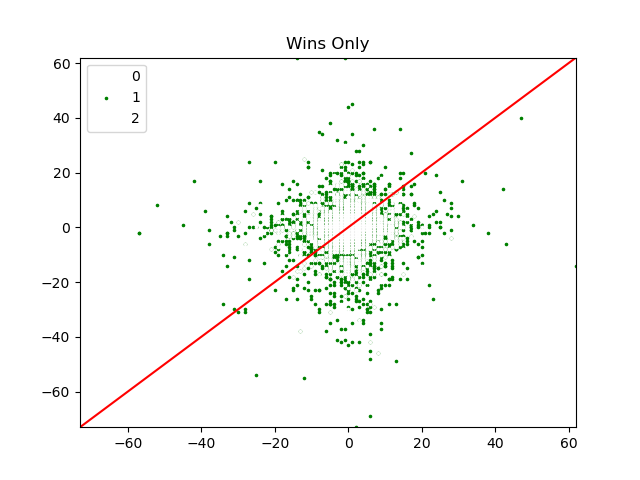

In [1302]:
cdict = {1:'green',0:'white',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Wins Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

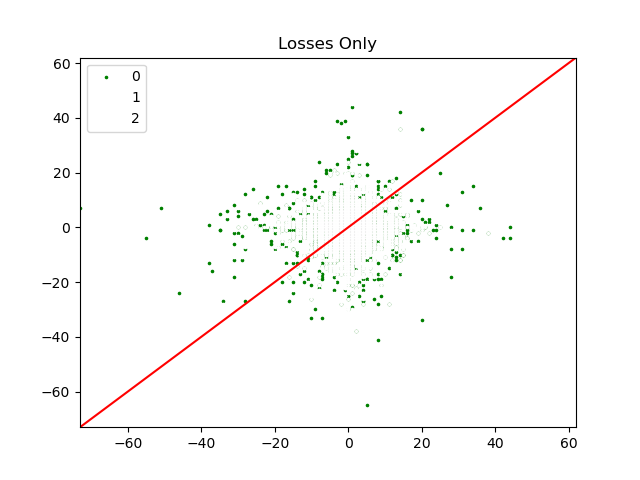

In [1303]:
cdict = {1:'white',0:'green',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Losses Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

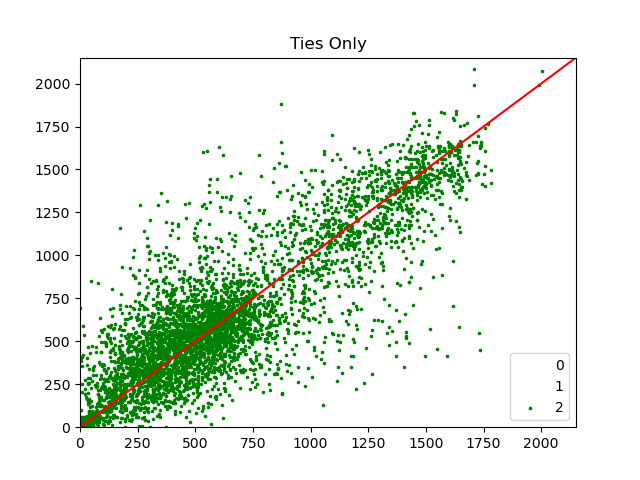

In [1304]:
rankA = historic_matches_ranked["previous_points_home"]
rankA = rankA.to_numpy()
rankB = historic_matches_ranked["previous_points_away"]
rankB = rankB.to_numpy()
outcomes = historic_matches_ranked[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final"] = historic_matches_ranked.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
outcomes_r = outcomes["final"]
outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
cdict = {1:'white',0:'white',2:'green'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Ties Only")
plt.show()
#fig = plt.figure()

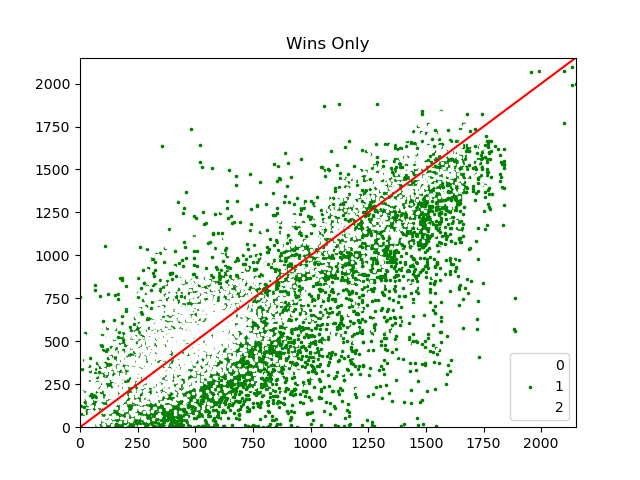

In [1305]:
cdict = {1:'green',0:'white',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Wins Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

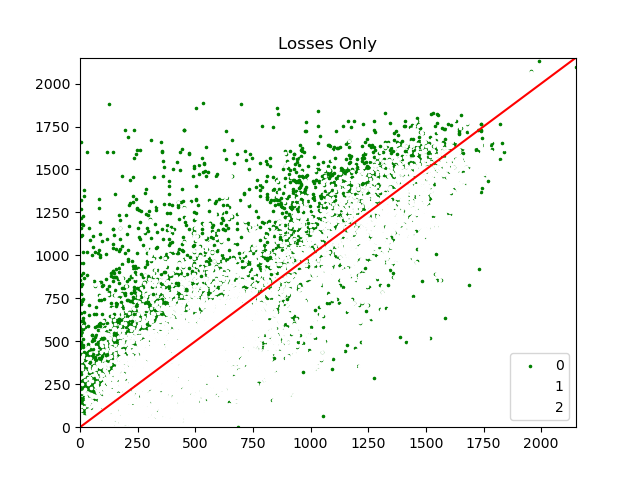

In [1306]:
cdict = {1:'white',0:'green',2:'white'}
fig, ax = plt.subplots()
for g in np.unique(outcomes_r):
    ix = np.where(outcomes_r == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 10)
ax.legend()
lineStart = min(min(rankA),min(rankB))
lineEnd = max(max(rankA),max(rankB))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.title("Losses Only")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

In [1307]:
rankA = historic_matches_ranked["del_rank"]
rankA = rankA.to_numpy()
#rankB = historic_matches_ranked["rank_away"]
#rankB = rankB.to_numpy()
outcomes = historic_matches_ranked[["Target_Outcome_Win","Target_Outcome_Loss"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final"] = historic_matches_ranked.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else -1 if (row.Target_Outcome_Loss==1) else 0,axis=1)
outcomes["rank_difference"] = rankA
outcomes_win = outcomes[outcomes["final"]==1]
stat = outcomes.groupby("final")
team_char= stat.mean()
print(team_char)
outcomes_loss = outcomes[outcomes["final"]==-1]
outcomes_tie = outcomes[outcomes["final"]==-0]
outcomes_r = outcomes["final"]
#outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
index_win = np.argwhere(outcomes_r == 1)
index_loss = np.argwhere(outcomes_r == -1)
index_tie = np.argwhere(outcomes_r == 0)
data = [rankA[index_loss],rankA[index_tie],rankA[index_win]]
#print(data)
#fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1,1])
 
# Creating plot
#bp = plt.boxplot(data[2])
sns.violinplot(data=outcomes,x="final",y="rank_difference") 
# show plot
#plt.show()

#Not visually appealing!

       Target_Outcome_Win  Target_Outcome_Loss  rank_difference
final                                                          
-1                    0.0                  1.0        31.047604
 0                    0.0                  0.0         4.162182
 1                    1.0                  0.0       -26.027274


<Axes: title={'center': 'Losses Only'}, xlabel='final', ylabel='rank_difference'>

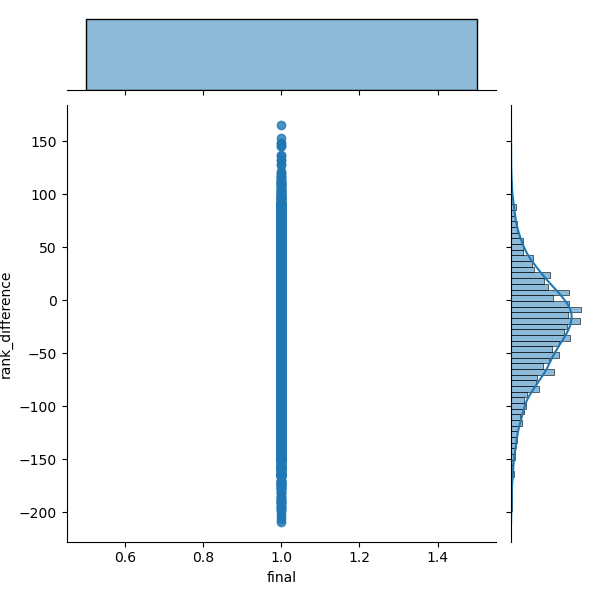

In [1308]:
sns.jointplot(data = outcomes_win, y = 'rank_difference', x = 'final', kind="reg")

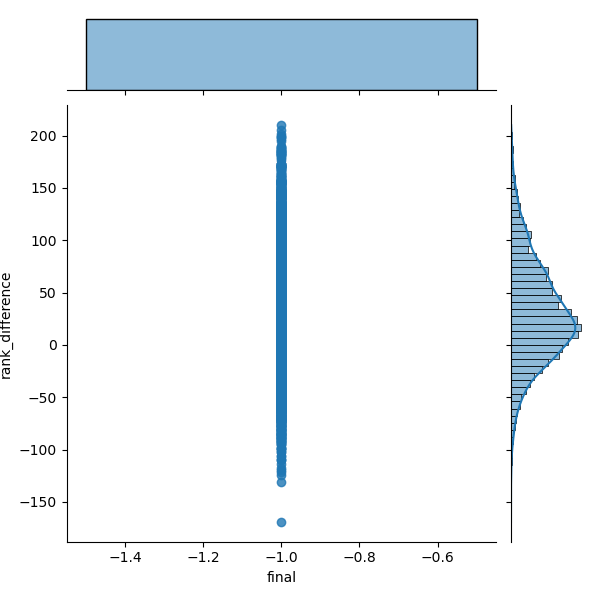

In [1309]:
sns.jointplot(data = outcomes_loss, y = 'rank_difference', x = 'final', kind="reg")

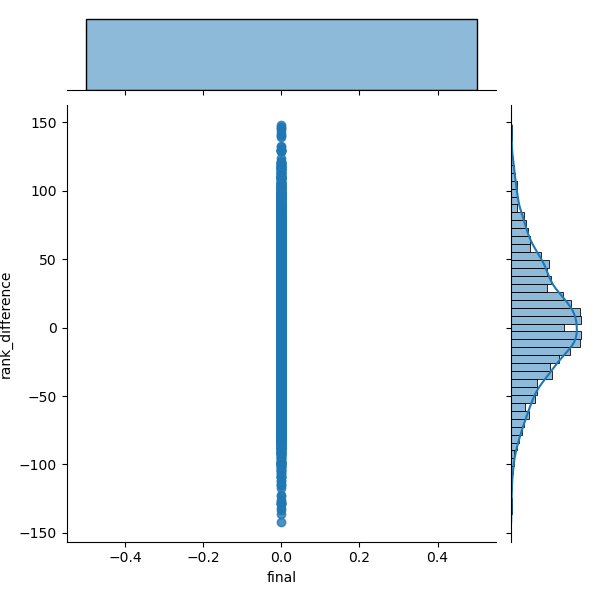

In [1310]:
sns.jointplot(data = outcomes_tie, y = 'rank_difference', x = 'final', kind="reg")

# Adding New Features

In [1311]:
#Add new features derived from historical match data
# Goals taken and scored against in the last n matches (?)
# Binary features
A_team =historic_matches_ranked[["date", "home_team","home_score","away_score","rank_home", "rank_away","rank_change_home", "total_points_home", "Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]

B_team = historic_matches_ranked[["date", "away_team","home_score","away_score",  "rank_away", "rank_home","rank_change_away", "total_points_away", "Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]

In [1312]:
A_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in A_team.columns]

B_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in B_team.columns]

In [1313]:
team_stats = pd.concat([A_team,B_team],ignore_index=True)
team_stats.head(5)

date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0

In [1314]:

n_historic_window = 5 #5 years
n_games = 10 #Number of games to consider
def generate_unary_team_histoy(team_stats,n_historic_window,n_games):
    print(team_stats.head(5))
    stats_val = []
    for index, row in tqdm(team_stats.iterrows()):
        team = row["team"]
        date = row["date"]
        past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date) & (team_stats['date'] > date- n_historic_window*pd.Timedelta(days=365) )].sort_values(by=['date'], ascending=False)
        lastn = past_games.head(n_games)
        
        goals = past_games["score"].mean()
        goals_ln = lastn["score"].mean()
        
        goals_suf = past_games["suf_score"].mean()
        goals_suf_ln = lastn["suf_score"].mean()
        
        rank = past_games["rank_suf"].mean()
        rank_ln = lastn["rank_suf"].mean()
        
        if len(lastn) > 0:
            points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
            points_ln = lastn["total_points"].values[0] - lastn["total_points"].values[-1] 
        else:
            points = 0
            points_ln = 0
            
        gp = past_games["total_points"].mean()
        gp_ln = lastn["total_points"].mean()
        

        
        stats_val.append([goals, goals_ln, goals_suf, goals_suf_ln, rank, rank_ln,points,points_ln,gp,gp_ln])
    stats_cols = ["goals_mean", "goals_mean_ln", "goals_suf_mean", "goals_suf_mean_ln", "rank_mean", "rank_mean_ln","points","points_ln",  "game_points_mean", "game_points_mean_ln"]

    stats_df = pd.DataFrame(stats_val, columns=stats_cols)
    full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)
    A_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
    B_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]
    A_team_stats = A_team_stats[A_team_stats.columns[-10:]]
    B_team_stats = B_team_stats[B_team_stats.columns[-10:]]
    A_team_stats.columns = ['home_'+str(col) for col in A_team_stats.columns]
    B_team_stats.columns = ['away_'+str(col) for col in B_team_stats.columns]
    match_stats = pd.concat([A_team_stats, B_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
    detailed_historical_matches_ranked = pd.concat([historic_matches_ranked, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)
    return detailed_historical_matches_ranked

In [1315]:
#stats_val = generate_unary_team_histoy(team_stats,5,5)
#print(stats_val)
#stats_cols = ["goals_mean", "goals_mean_ln", "goals_suf_mean", "goals_suf_mean_ln", "rank_mean", "rank_mean_ln","points","points_ln",  "game_points_mean", "game_points_mean_ln"]

#stats_df = pd.DataFrame(stats_val, columns=stats_cols)
#stats_df = generate_unary_team_histoy(team_stats,5,10)
#full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [1316]:
#full_df.head(5)

In [1317]:
#A_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
#B_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [1318]:
#A_team_stats.columns[-10:]

In [1319]:
#B_team_stats.columns[-10:]

In [1320]:
#A_team_stats = A_team_stats[A_team_stats.columns[-10:]]
#B_team_stats = B_team_stats[B_team_stats.columns[-10:]]

In [1321]:
#A_team_stats.columns = ['home_'+str(col) for col in A_team_stats.columns]
#B_team_stats.columns = ['away_'+str(col) for col in B_team_stats.columns]

In [1322]:
#match_stats = pd.concat([A_team_stats, B_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
#detailed_historical_matches_ranked = pd.concat([historic_matches_ranked, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)
detailed_historical_matches_ranked = generate_unary_team_histoy(team_stats,5,5)

        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:39, 468.12it/s]


In [1323]:
detailed_historical_matches_ranked.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'GoalDifference', 'Target_Outcome_Win',
       'Target_Outcome_Loss', 'Target_Outcome_Tie', 'del_rank',
       'home_goals_mean', 'home_goals_mean_ln', 'home_goals_suf_mean',
       'home_goals_suf_mean_ln', 'home_rank_mean', 'home_rank_mean_ln',
       'home_points', 'home_points_ln', 'home_game_points_mean',
       'home_game_points_mean_ln', 'away_goals_mean', 'away_goals_mean_ln',
       'away_goals_suf_mean', 'away_goals_suf_mean_ln', 'away_rank_mean',
       'away_rank_mean_ln', 'away_points', 'away_points_ln',
       'away_game_points_mean', 'away_game_points_mean_ln'],
      dtype='object')

        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 477.35it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 477.08it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:36, 479.95it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 475.39it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:36, 481.70it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 474.87it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:36, 479.18it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 478.18it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 477.52it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 475.60it/s]


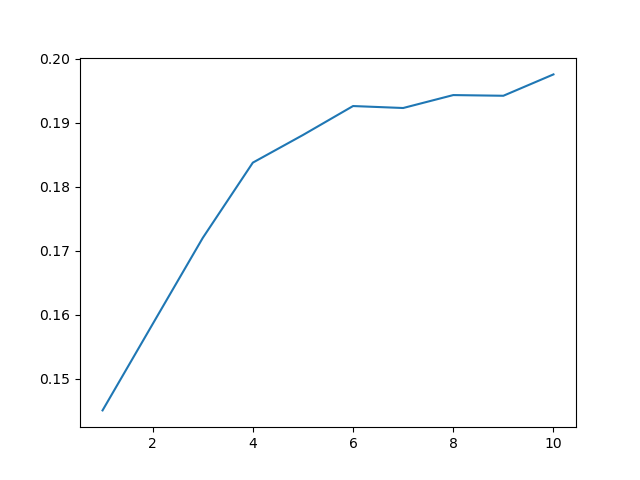

In [1324]:
plt.clf()
#%matplotlib inline
# Find the golden n_window, n_matches
history = [1,2,3,4,5,6,7,8,9,10]
#history =[1]
date_start = pd.to_datetime('1993-01-01')
correl = []
fig,ax = plt.subplots()
for years in history:
    hist_matrix = generate_unary_team_histoy(team_stats,years,5)
    hist_matrix =  hist_matrix[hist_matrix["date"] >= date_start + years* pd.Timedelta(days=365)]
    #hist_matrix = hist_matrix['home_goals_mean','Target_Outcome_Win']
    corr1_matrix = hist_matrix[["home_goals_mean","Target_Outcome_Win"]].corr(method = 'pearson')
    data = corr1_matrix["home_goals_mean"]["Target_Outcome_Win"]
    correl.append(data)
plt.plot(history,correl)   
plt.show() 

        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:40, 462.38it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 477.62it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:37, 478.57it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:38, 472.65it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:39, 468.50it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:39, 468.70it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:38, 470.39it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:40, 460.17it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:40, 463.16it/s]


        date          team  score  suf_score  rank  rank_suf  rank_change  \
0 1993-01-01         Ghana      1          1  39.0      69.0          0.0   
1 1993-01-02         Gabon      1          1  55.0      97.0          0.0   
2 1993-01-03  Burkina Faso      1          0  97.0      69.0          0.0   
3 1993-01-03         Gabon      2          3  55.0      39.0          0.0   
4 1993-01-08        Uganda      3          1  92.0      80.0          0.0   

   total_points  Target_Outcome_Win  Target_Outcome_Loss  Target_Outcome_Tie  
0          34.0                   0                    0                   1  
1          27.0                   0                    0                   1  
2          11.0                   1                    0                   0  
3          27.0                   0                    1                   0  
4          12.0                   1                    0                   0  


46454it [01:36, 481.13it/s]


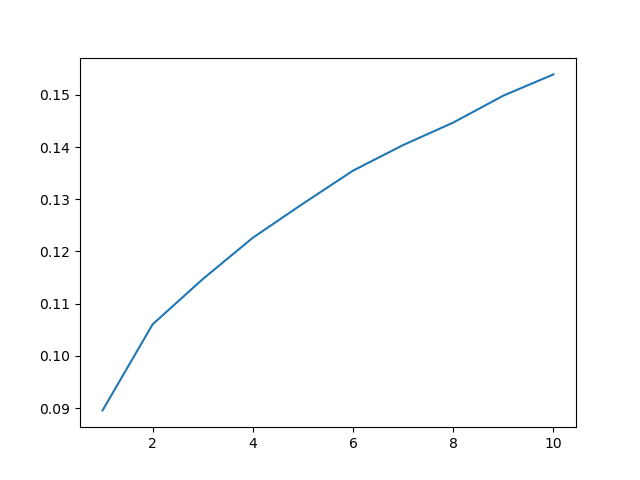

In [1326]:


#%matplotlib inline
# Find the golden n_window, n_matches
history = [1,2,3,4,5,6,7,8,9,10]
#history =[1]
date_start = pd.to_datetime('1993-01-01')
correl = []
fig,ax = plt.subplots()
for matches in history:
    years=5
    hist_matrix = generate_unary_team_histoy(team_stats,5,matches)
    hist_matrix =  hist_matrix[hist_matrix["date"] >= date_start + years* pd.Timedelta(days=365)]
    #hist_matrix = hist_matrix['home_goals_mean','Target_Outcome_Win']
    corr1_matrix = hist_matrix[["home_goals_mean_ln","Target_Outcome_Win"]].corr(method = 'pearson')
    data = corr1_matrix["home_goals_mean_ln"]["Target_Outcome_Win"]
    correl.append(data)
plt.plot(history,correl)   
plt.show() 

In [ ]:
# Add face to face data (Long time to run!)
stats_val = []
n_historic_window_f2f = 10 #5 years
#n_games = 5 #Number of games to consider
for index, row in tqdm(detailed_historical_matches_ranked.iterrows()):
    teamA = row["home_team"]
    teamB = row["away_team"]
    date = row["date"]
    past_games_AvB = detailed_historical_matches_ranked[(detailed_historical_matches_ranked['home_team'] == teamA)&((detailed_historical_matches_ranked['away_team'] == teamB)) & (detailed_historical_matches_ranked["date"] < date) & (detailed_historical_matches_ranked['date'] > date- n_historic_window_f2f*pd.Timedelta(days=365) )].sort_values(by=['date'], ascending=False)
    #lastn = past_games.head(n_games)
    n_AvB = past_games_AvB.shape[0]
    goals_by_A = 0
    goals_by_B = 0
    won_by_A =0 
    won_by_B = 0
    tied_AvB = 0
    goals_by_A = past_games_AvB["home_score"].sum() + goals_by_A
    goals_by_B = past_games_AvB["away_score"].sum() +goals_by_B
    won_by_A = past_games_AvB["Target_Outcome_Win"].sum() +won_by_A
    won_by_B = past_games_AvB["Target_Outcome_Loss"].sum() + won_by_B
    tied_AvB = past_games_AvB["Target_Outcome_Tie"].sum() +tied_AvB
    past_games_BvA =detailed_historical_matches_ranked[(detailed_historical_matches_ranked['home_team'] == teamB)&((detailed_historical_matches_ranked['away_team'] == teamA)) & (detailed_historical_matches_ranked["date"] < date) & (detailed_historical_matches_ranked['date'] > date- n_historic_window_f2f*pd.Timedelta(days=365) )].sort_values(by=['date'], ascending=False)
    #lastn = past_games.head(n_games)
    n_BvA = past_games_BvA.shape[0]
    goals_by_A = past_games_BvA["away_score"].sum() + goals_by_A
    goals_by_B = past_games_BvA["home_score"].sum() +goals_by_B
    won_by_A = past_games_BvA["Target_Outcome_Loss"].sum() +won_by_A
    won_by_B = past_games_BvA["Target_Outcome_Win"].sum() + won_by_B
    tied_AvB = past_games_BvA["Target_Outcome_Tie"].sum() +tied_AvB
    if (n_AvB + n_BvA)!=0:
        goals_by_A = goals_by_A/(n_AvB+n_BvA)
        goals_by_B = goals_by_B/(n_AvB+n_BvA)

    
    #gp_rank = past_games["points_by_rank"].mean()
    #gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals_by_A,goals_by_B,won_by_A,won_by_B,tied_AvB])

23227it [01:33, 248.17it/s]


In [ ]:
stats_cols = ["goals_AvB_past","goals_BvA_past","A_victories","B_victories","Team_ties"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

detailed_historical_matches_ranked = pd.concat([detailed_historical_matches_ranked.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [ ]:
detailed_historical_matches_ranked.tail(20)
# I checked  a few .looks fine 

date      home_team            away_team  home_score  away_score  \
23207 2023-06-28        Jamaica  Trinidad and Tobago           4           1   
23208 2023-06-29          Qatar             Honduras           1           1   
23209 2023-06-29          Haiti               Mexico           1           3   
23210 2023-06-30    El Salvador           Costa Rica           0           0   
23211 2023-07-01          India              Lebanon           0           0   
23212 2023-07-01         Kuwait           Bangladesh           1           0   
23213 2023-07-01      Guatemala               Canada           0           0   
23214 2023-07-02  United States  Trinidad and Tobago           6           0   
23215 2023-07-02       Honduras                Haiti           2           1   
23216 2023-07-02         Mexico                Qatar           0           1   
23217 2023-07-04          India               Kuwait           1           1   
23218 2023-07-04         Panama          El Salvador           2           2   
23219 2023-07-04         Canada                 Cuba           4           2   
23220 2023-07-08         Panama                Qatar           4           0   
23221 2023-07-08         Mexico           Costa Rica           2           0   
23222 2023-07-09      Guatemala              Jamaica           0           1   
23223 2023-07-09  United States               Canada           2           2   
23224 2023-07-12  United States               Panama           1           1   
23225 2023-07-12        Jamaica               Mexico           0           3   
23226 2023-07-16         Mexico               Panama           1           0   

       tournament         city        country  neutral  total_points_home  \
23207           1    St. Louis  United States        1            1381.87   
23208           1     Glendale  United States        1            1393.52   
23209           1     Glendale  United States        1            1275.96   
23210           1     Harrison  United States        1            1317.64   
23211           1    Bengaluru          India        1            1204.90   
23212           1    Bengaluru          India        1            1084.34   
23213           1      Houston  United States        1            1166.60   
23214           1    Charlotte  United States        1            1673.34   
23215           1    Charlotte  United States        1            1296.42   
23216           1  Santa Clara  United States        1            1639.19   
23217           1    Bengaluru          India        1            1204.90   
23218           1      Houston  United States        1            1399.23   
23219           1      Houston  United States        1            1454.12   
23220           1    Arlington  United States        1            1399.23   
23221           1    Arlington  United States        1            1639.19   
23222           1   Cincinnati  United States        1            1166.60   
23223           1   Cincinnati  United States        1            1673.34   
23224           1    San Diego  United States        1            1673.34   
23225           1     Paradise  United States        1            1367.83   
23226           1    Inglewood  United States        1            1639.19   

       ...  away_rank_mean_ln  away_points  away_points_ln  \
23207  ...              122.4       -66.39            2.32   
23208  ...               49.6       -67.62           -1.60   
23209  ...               61.8      -409.13            0.00   
23210  ...               72.8        20.12           -9.06   
23211  ...              135.2      -101.26           -5.73   
23212  ...              162.6       -20.12           -0.57   
23213  ...               52.0       135.66          -32.34   
23214  ...              122.2       -66.39            2.32   
23215  ...              105.4        59.96            6.89   
23216  ...               73.8       157.52           -0.04   
23217  ...              154.0  

In [ ]:
detailed_historical_matches_ranked.columns
detailed_historical_matches_ranked = detailed_historical_matches_ranked[detailed_historical_matches_ranked["date"]>="2000-01-01"]

In [ ]:
detailed_historical_matches_ranked.isna().sum()

date                         0
home_team                    0
away_team                    0
home_score                   0
away_score                   0
tournament                   0
city                         0
country                      0
neutral                      0
total_points_home            0
previous_points_home         0
rank_home                    0
rank_change_home             0
total_points_away            0
previous_points_away         0
rank_away                    0
rank_change_away             0
GoalDifference               0
Target_Outcome_Win           0
Target_Outcome_Loss          0
Target_Outcome_Tie           0
del_rank                     0
home_goals_mean              9
home_goals_mean_ln           9
home_goals_suf_mean          9
home_goals_suf_mean_ln       9
home_rank_mean               9
home_rank_mean_ln            9
home_points                  0
home_points_ln               0
home_game_points_mean        9
home_game_points_mean_ln     9
away_goa

In [ ]:
detailed_historical_matches_ranked_clean = detailed_historical_matches_ranked.fillna(0)
detailed_historical_matches_ranked_clean = detailed_historical_matches_ranked_clean.reset_index()

In [ ]:
detailed_historical_matches_ranked_clean.head(5)

index       date            home_team away_team  home_score  away_score  \
0   4292 2000-01-04                Egypt      Togo           2           1   
1   4293 2000-01-07              Tunisia      Togo           7           0   
2   4294 2000-01-08  Trinidad and Tobago    Canada           0           0   
3   4295 2000-01-09         Burkina Faso     Gabon           1           1   
4   4296 2000-01-09            Guatemala   Armenia           1           1   

   tournament           city              country  neutral  ...  \
0           0          Aswan                Egypt        1  ...   
1           0          Tunis              Tunisia        1  ...   
2           0  Port of Spain  Trinidad and Tobago        1  ...   
3           0    Ouagadougou         Burkina Faso        1  ...   
4           0    Los Angeles        United States        1  ...   

   away_rank_mean_ln  away_points  away_points_ln  away_game_points_mean  \
0              104.0        395.0            -4.0             102.080000   
1               84.0        392.0            -4.0             109.980000   
2               72.4        370.0             5.0             128.842105   
3               91.8        424.0             7.0             151.489796   
4               57.6        399.0             2.0             113.351351   

   away_game_points_mean_ln  goals_AvB_past  goals_BvA_past  A_victories  \
0                     418.4        5.000000             1.0            2   
1                     417.6        2.000000             0.5            2   
2                     396.0        1.000000             3.0            0   
3                     447.8        1.285714             2.0            1   
4                     407.0        0.000000             0.0            0   

   B_victories  Team_ties  
0            0          0  
1            0          0  
2            1          0  
3            3          3  
4            0          0  

[5 rows x 48 columns]

In [ ]:
detailed_historical_matches_ranked_clean.isna().sum()

index                       0
date                        0
home_team                   0
away_team                   0
home_score                  0
away_score                  0
tournament                  0
city                        0
country                     0
neutral                     0
total_points_home           0
previous_points_home        0
rank_home                   0
rank_change_home            0
total_points_away           0
previous_points_away        0
rank_away                   0
rank_change_away            0
GoalDifference              0
Target_Outcome_Win          0
Target_Outcome_Loss         0
Target_Outcome_Tie          0
del_rank                    0
home_goals_mean             0
home_goals_mean_ln          0
home_goals_suf_mean         0
home_goals_suf_mean_ln      0
home_rank_mean              0
home_rank_mean_ln           0
home_points                 0
home_points_ln              0
home_game_points_mean       0
home_game_points_mean_ln    0
away_goals

In [ ]:
#Time to re-do correlation analysis (oh boy)
# CORRELATION MATRIX PRESENT
corr_matrix =detailed_historical_matches_ranked_clean[["rank_home","rank_away", "del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean','home_goals_suf_mean_ln', 'home_rank_mean',
       'home_rank_mean_ln', 'home_points', 'home_points_ln',
       'home_game_points_mean', 'home_game_points_mean_ln', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean',
       'away_goals_suf_mean_ln', 'away_rank_mean', 'away_rank_mean_ln',
       'away_points', 'away_points_ln', 'away_game_points_mean',
       'away_game_points_mean_ln', 'goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories', 'Team_ties',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

In [ ]:
np.abs(corr_matrix["Team_ties"]["Target_Outcome_Win"])

0.03512120063168777

In [1404]:
detailed_historical_matches_ranked_clean.head(5)

index       date            home_team away_team  home_score  away_score  \
0   4292 2000-01-04                Egypt      Togo           2           1   
1   4293 2000-01-07              Tunisia      Togo           7           0   
2   4294 2000-01-08  Trinidad and Tobago    Canada           0           0   
3   4295 2000-01-09         Burkina Faso     Gabon           1           1   
4   4296 2000-01-09            Guatemala   Armenia           1           1   

   tournament           city              country  neutral  ...  \
0           0          Aswan                Egypt        1  ...   
1           0          Tunis              Tunisia        1  ...   
2           0  Port of Spain  Trinidad and Tobago        1  ...   
3           0    Ouagadougou         Burkina Faso        1  ...   
4           0    Los Angeles        United States        1  ...   

   away_rank_mean_ln  away_points  away_points_ln  away_game_points_mean  \
0              104.0        395.0            -4.0             102.080000   
1               84.0        392.0            -4.0             109.980000   
2               72.4        370.0             5.0             128.842105   
3               91.8        424.0             7.0             151.489796   
4               57.6        399.0             2.0             113.351351   

   away_game_points_mean_ln  goals_AvB_past  goals_BvA_past  A_victories  \
0                     418.4        5.000000             1.0            2   
1                     417.6        2.000000             0.5            2   
2                     396.0        1.000000             3.0            0   
3                     447.8        1.285714             2.0            1   
4                     407.0        0.000000             0.0            0   

   B_victories  Team_ties  
0            0          0  
1            0          0  
2            1          0  
3            3          3  
4            0          0  

[5 rows x 48 columns]

In [ ]:
corr_threshold = 0.1 #Sets the correlation threshold to select or reject a particular feature
feature_candidates = ["rank_home","rank_away", "del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean','home_goals_suf_mean_ln', 'home_rank_mean',
       'home_rank_mean_ln', 'home_points', 'home_points_ln',
       'home_game_points_mean', 'home_game_points_mean_ln', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean',
       'away_goals_suf_mean_ln', 'away_rank_mean', 'away_rank_mean_ln',
       'away_points', 'away_points_ln', 'away_game_points_mean',
       'away_game_points_mean_ln', 'goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories','Team_ties']
target_list = ["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]
def choose_features(corr_matrix,feature_list,target_list,corr_threshold):
    features_accept = []
    for features in feature_list:
        n_accept = 0
        for target in target_list:
            if np.abs(corr_matrix[features][target]) >= corr_threshold:
                n_accept+=1
        if n_accept >=1:
            features_accept.append(features)
    return features_accept                

In [ ]:
choose_features(corr_matrix,feature_candidates,target_list,corr_threshold)

['rank_home',
 'rank_away',
 'del_rank',
 'home_goals_mean',
 'home_goals_mean_ln',
 'home_goals_suf_mean',
 'home_goals_suf_mean_ln',
 'home_rank_mean',
 'home_game_points_mean',
 'home_game_points_mean_ln',
 'away_goals_mean',
 'away_goals_mean_ln',
 'away_goals_suf_mean',
 'away_goals_suf_mean_ln',
 'away_rank_mean',
 'away_rank_mean_ln',
 'away_game_points_mean',
 'away_game_points_mean_ln',
 'goals_AvB_past',
 'goals_BvA_past',
 'A_victories',
 'B_victories']

In [ ]:
detailed_historical_matches_ranked_clean.to_csv('master_dataset.csv',index=False)

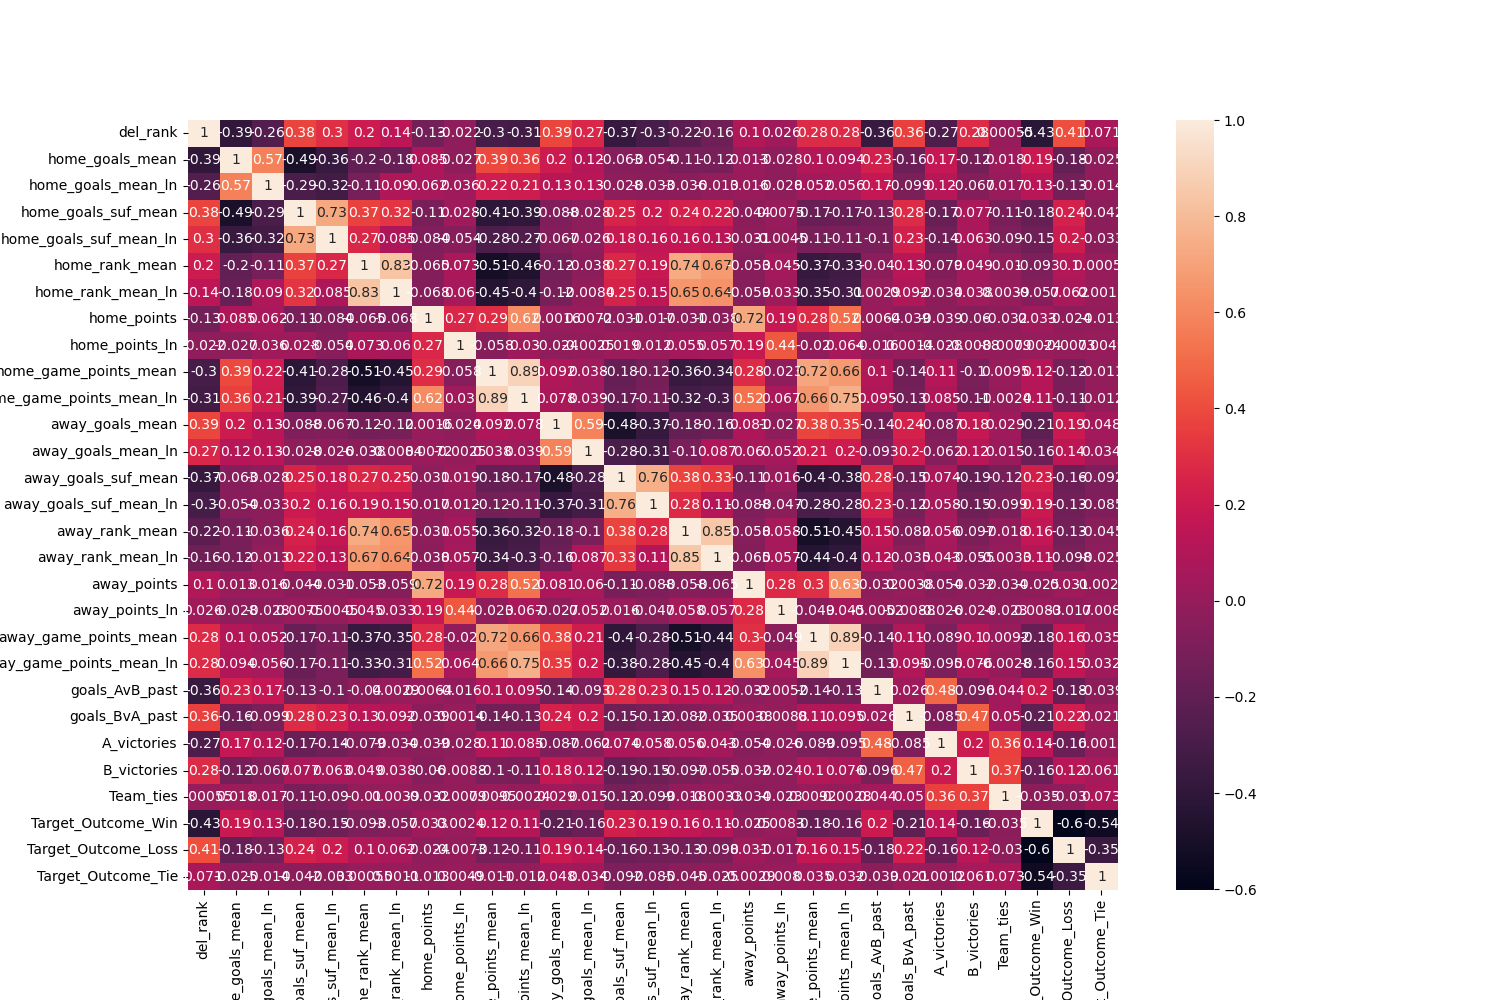

In [1405]:
# 31 features looks like a bad time
#HEat map
# TODO: AVERAGE GOALS

plt.figure(figsize=(15, 10))
sns.heatmap(detailed_historical_matches_ranked_clean[[ "del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean','home_goals_suf_mean_ln', 'home_rank_mean',
       'home_rank_mean_ln', 'home_points', 'home_points_ln',
       'home_game_points_mean', 'home_game_points_mean_ln', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean',
       'away_goals_suf_mean_ln', 'away_rank_mean', 'away_rank_mean_ln',
       'away_points', 'away_points_ln', 'away_game_points_mean',
       'away_game_points_mean_ln', 'goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories', 'Team_ties',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson'), annot=True)
plt.show()

In [1407]:
#Friendly not good indicator.
detailed_historical_matches_ranked_clean[[ "tournament","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

tournament  Target_Outcome_Win  Target_Outcome_Loss  \
tournament             1.000000            0.006802             0.043627   
Target_Outcome_Win     0.006802            1.000000            -0.601730   
Target_Outcome_Loss    0.043627           -0.601730             1.000000   
Target_Outcome_Tie    -0.054047           -0.537214            -0.350403   

                     Target_Outcome_Tie  
tournament                    -0.054047  
Target_Outcome_Win            -0.537214  
Target_Outcome_Loss           -0.350403  
Target_Outcome_Tie             1.000000

In [1408]:
detailed_historical_matches_ranked_clean[[ "neutral","Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

neutral  Target_Outcome_Win  Target_Outcome_Loss  \
neutral                  NaN                 NaN                  NaN   
Target_Outcome_Win       NaN            1.000000            -0.601730   
Target_Outcome_Loss      NaN           -0.601730             1.000000   
Target_Outcome_Tie       NaN           -0.537214            -0.350403   

                     Target_Outcome_Tie  
neutral                             NaN  
Target_Outcome_Win            -0.537214  
Target_Outcome_Loss           -0.350403  
Target_Outcome_Tie             1.000000

In [1411]:
#Group and Analyse
#Threshold at least abs(one outcome) >0.1
# if correlation to another varaibale >0.7 ,one of the variables retained. 
#Binary features
from sklearn.feature_selection import mutual_info_regression

def custom_mi_reg(a, b):
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    return  mutual_info_regression(a, b)[0] # should return a float value
    
    
#df_mi = df.corr(method=custom_mi_reg)
#sns.heatmap(detailed_historical_matches_ranked_clean[[ 'goals_AvB_past', 'goals_BvA_past',
#       'A_victories', 'B_victories', 'Team_ties',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method=custom_mi_reg) )
#plt.show()
detailed_historical_matches_ranked_clean[[ 'goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories', 'Team_ties',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method=custom_mi_reg)

goals_AvB_past  goals_BvA_past  A_victories  B_victories  \
goals_AvB_past             1.000000        0.664587     0.568735     0.312029   
goals_BvA_past             0.664587        1.000000     0.319245     0.537985   
A_victories                0.568735        0.319245     1.000000     0.024135   
B_victories                0.312029        0.537985     0.024135     1.000000   
Team_ties                  0.273119        0.262627     0.056942     0.064696   
Target_Outcome_Win         0.029375        0.029531     0.012216     0.007921   
Target_Outcome_Loss        0.025854        0.027186     0.021931     0.003755   
Target_Outcome_Tie         0.004273        0.007554     0.016286     0.004688   

                     Team_ties  Target_Outcome_Win  Target_Outcome_Loss  \
goals_AvB_past        0.273119            0.029375             0.025854   
goals_BvA_past        0.262627            0.029531             0.027186   
A_victories           0.056942            0.012216             0.021931   
B_victories           0.064696            0.007921             0.003755   
Team_ties             1.000000            0.000000             0.012749   
Target_Outcome_Win    0.000000            1.000000             0.240385   
Target_Outcome_Loss   0.012749            0.240385             1.000000   
Target_Outcome_Tie    0.008552            0.185804             0.094243   

                     Target_Outcome_Tie  
goals_AvB_past                 0.004273  
goals_BvA_past                 0.007554  
A_victories                    0.016286  
B_victories                    0.004688  
Team_ties                      0.008552  
Target_Outcome_Win             0.185804  
Target_Outcome_Loss            0.094243  
Target_Outcome_Tie             1.000000

In [1388]:
detailed_historical_matches_ranked_clean[[ 'goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')
#Team_Ties Elimintaed

goals_AvB_past  goals_BvA_past  A_victories  B_victories  \
goals_AvB_past             1.000000        0.026302     0.482663    -0.096300   
goals_BvA_past             0.026302        1.000000    -0.084664     0.466387   
A_victories                0.482663       -0.084664     1.000000     0.195619   
B_victories               -0.096300        0.466387     0.195619     1.000000   
Target_Outcome_Win         0.197223       -0.211803     0.141400    -0.163601   
Target_Outcome_Loss       -0.182388        0.215061    -0.158116     0.123909   
Target_Outcome_Tie        -0.038668        0.021263     0.001161     0.060996   

                     Target_Outcome_Win  Target_Outcome_Loss  \
goals_AvB_past                 0.197223            -0.182388   
goals_BvA_past                -0.211803             0.215061   
A_victories                    0.141400            -0.158116   
B_victories                   -0.163601             0.123909   
Target_Outcome_Win             1.000000            -0.601730   
Target_Outcome_Loss           -0.601730             1.000000   
Target_Outcome_Tie            -0.537214            -0.350403   

                     Target_Outcome_Tie  
goals_AvB_past                -0.038668  
goals_BvA_past                 0.021263  
A_victories                    0.001161  
B_victories                    0.060996  
Target_Outcome_Win            -0.537214  
Target_Outcome_Loss           -0.350403  
Target_Outcome_Tie             1.000000

In [1389]:
detailed_historical_matches_ranked_clean[[ "del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean','home_goals_suf_mean_ln', 
         "Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')
# Things in column retained are the chosen ones
# SOME ln and mean datas to be removed.
b = detailed_historical_matches_ranked_clean[[ "del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean','home_goals_suf_mean_ln', 
         "Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

In [1390]:
b["del_rank"]["Target_Outcome_Win"]

-0.4258176528095612

In [1412]:
detailed_historical_matches_ranked_clean[[ "del_rank", 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean',
       'away_goals_suf_mean_ln',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method=custom_mi_reg)

del_rank  away_goals_mean  away_goals_mean_ln  \
del_rank                1.000000         0.125783            0.057543   
away_goals_mean         0.125783         1.000000            0.259398   
away_goals_mean_ln      0.057543         0.259398            1.000000   
away_goals_suf_mean     0.133679         0.322065            0.088399   
away_goals_suf_mean_ln  0.066006         0.114376            0.081752   
Target_Outcome_Win      0.094448         0.034447            0.014552   
Target_Outcome_Loss     0.093826         0.013841            0.012066   
Target_Outcome_Tie      0.011544         0.009839            0.000000   

                        away_goals_suf_mean  away_goals_suf_mean_ln  \
del_rank                           0.133679                0.066006   
away_goals_mean                    0.322065                0.114376   
away_goals_mean_ln                 0.088399                0.081752   
away_goals_suf_mean                1.000000                0.316041   
away_goals_suf_mean_ln             0.316041                1.000000   
Target_Outcome_Win                 0.036715                0.021074   
Target_Outcome_Loss                0.016863                0.004930   
Target_Outcome_Tie                 0.004546                0.000000   

                        Target_Outcome_Win  Target_Outcome_Loss  \
del_rank                          0.094448             0.093826   
away_goals_mean                   0.034447             0.013841   
away_goals_mean_ln                0.014552             0.012066   
away_goals_suf_mean               0.036715             0.016863   
away_goals_suf_mean_ln            0.021074             0.004930   
Target_Outcome_Win                1.000000             0.238236   
Target_Outcome_Loss               0.238236             1.000000   
Target_Outcome_Tie                0.184328             0.090608   

                        Target_Outcome_Tie  
del_rank                          0.011544  
away_goals_mean                   0.009839  
away_goals_mean_ln                0.000000  
away_goals_suf_mean               0.004546  
away_goals_suf_mean_ln            0.000000  
Target_Outcome_Win                0.184328  
Target_Outcome_Loss               0.090608  
Target_Outcome_Tie                1.000000

In [1392]:
# Features
#del_rank
#goal_A_mean_past
#goal_A_mean_past_n_games
#goal_A_suff_mean
#goal_B_mean_past
#goal_B_mean_past_n_games
#goal_B_suff_mean
#goals_AvB_past 
#goals_BvA_past
#'A_victories' 
#'B_victories'
#cRITERIA : At least one of outcomes correlation >0.1(absolute value)
#thats it.
final_dataset_no_pca = detailed_historical_matches_ranked_clean[['date', 'home_team', 'away_team','tournament',"del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean','goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]] 
final_dataset_no_pca.to_csv("CorrCorrectedData.csv",index=False)

In [1393]:
#Final correlation Matrix
detailed_historical_matches_ranked_clean[["del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean','goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories',"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr() 

del_rank  home_goals_mean  home_goals_mean_ln  \
del_rank             1.000000        -0.391882           -0.255428   
home_goals_mean     -0.391882         1.000000            0.574953   
home_goals_mean_ln  -0.255428         0.574953            1.000000   
home_goals_suf_mean  0.380057        -0.490393           -0.286411   
away_goals_mean      0.386497         0.201580            0.131805   
away_goals_mean_ln   0.266464         0.115086            0.126292   
away_goals_suf_mean -0.370208        -0.063297           -0.027919   
goals_AvB_past      -0.360200         0.232605            0.170584   
goals_BvA_past       0.364260        -0.158489           -0.099099   
A_victories         -0.273107         0.172793            0.120685   
B_victories          0.282887        -0.120053           -0.066501   
Target_Outcome_Win  -0.425818         0.187449            0.126118   
Target_Outcome_Loss  0.405986        -0.184664           -0.126394   
Target_Outcome_Tie   0.070606        -0.024804           -0.014418   

                     home_goals_suf_mean  away_goals_mean  away_goals_mean_ln  \
del_rank                        0.380057         0.386497            0.266464   
home_goals_mean                -0.490393         0.201580            0.115086   
home_goals_mean_ln             -0.286411         0.131805            0.126292   
home_goals_suf_mean             1.000000        -0.088229           -0.028361   
away_goals_mean                -0.088229         1.000000            0.586618   
away_goals_mean_ln             -0.028361         0.586618            1.000000   
away_goals_suf_mean             0.251190        -0.483573           -0.283822   
goals_AvB_past                 -0.127683        -0.136110           -0.092978   
goals_BvA_past                  0.284016         0.239225            0.199207   
A_victories                    -0.170469        -0.087115           -0.061768   
B_victories                     0.077084         0.179078            0.123796   
Target_Outcome_Win             -0.179956        -0.213319           -0.158943   
Target_Outcome_Loss             0.239745         0.191033            0.144077   
Target_Outcome_Tie             -0.042150         0.048414            0.034236   

                     away_goals_suf_mean  goals_AvB_past  goals_BvA_past  \
del_rank                       -0.370208       -0.360200        0.364260   
home_goals_mean                -0.063297        0.232605       -0.158489   
home_goals_mean_ln             -0.027919        0.170584       -0.099099   
home_goals_suf_mean             0.251190       -0.127683        0.284016   
away_goals_mean                -0.483573       -0.136110        0.239225   
away_goals_mean_ln             -0.283822       -0.092978        0.199207   
away_goals_suf_mean             1.000000        0.283754       -0.151865   
goals_AvB_past                  0.283754        1.000000        0.026302   
goals_BvA_past                 -0.151865        0.026302        1.000000   
A_victories                     0.074235        0.482663       -0.084664   
B_victories                    -0.186041       -0.096300        0.466387   
Target_Outcome_Win              0.225189        0.197223       -0.211803   
Target_Outcome_Loss            -0.162930       -0.182388        0.215061   
Target_Outcome_Tie             -0.092010       -0.038668        0.021263   

                     A_victories  B_victories  Target_Outcome_Win  \
del_rank               -0.273107     0.282887           -0.425818   
home_goals_mean         0.172793    -0.120053            0.187449   
home_goals_mean_ln      0.120685    -0.066501            0.126118   
home_goals_suf_mean    -0.170469     0.077084           -0.179956   
away_goals_mean        -0.087115     0.179078           -0.213319   
away_goals_mean_ln     -0.061768     0.123796           -0.158943   
away_goals_suf_mean     0.074235    -0.186041            0.225189   
goals_AvB_past          0.482663    -0.096300            0.19

# Principal Component Analysis

In [1394]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
chosen_features = ["del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean','goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories']
pca = PCA(n_components=4, svd_solver='full')
scaler = StandardScaler()
final_dataset_filtered = final_dataset_no_pca[chosen_features]
final_dataset_filtered = final_dataset_filtered.to_numpy()
final_dataset_filtered = scaler.fit_transform(final_dataset_filtered)
pca.fit(final_dataset_filtered)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
#Join with the usual suspects
X_reduced = pca.fit_transform(final_dataset_filtered, y=None)
print("Shape of X is",X_reduced.shape)

[0.26057089 0.2074686  0.13634898 0.08997551]
[232.9656783  207.87639679 168.52135374 136.89612765]
Shape of X is (18935, 4)


In [1395]:
feature_df = pd.DataFrame(X_reduced,columns=['X_Principal0','X_Principal1','X_Principal2','XPrincipal3'])
feature_df[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]] = final_dataset_no_pca[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
feature_df[['date', 'home_team', 'away_team','tournament']] = final_dataset_no_pca[['date', 'home_team', 'away_team','tournament']]
feature_df[['X_Principal0','X_Principal1','X_Principal2','XPrincipal3' ,"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

X_Principal0  X_Principal1  X_Principal2   XPrincipal3  \
X_Principal0         1.000000e+00  1.376642e-16 -3.281590e-16  2.059855e-17   
X_Principal1         1.376642e-16  1.000000e+00  1.172223e-17 -2.928845e-16   
X_Principal2        -3.281590e-16  1.172223e-17  1.000000e+00 -2.600668e-16   
XPrincipal3          2.059855e-17 -2.928845e-16 -2.600668e-16  1.000000e+00   
Target_Outcome_Win  -4.199583e-01 -2.590251e-02 -1.210513e-03  6.484095e-03   
Target_Outcome_Loss  4.013899e-01 -1.659788e-02  7.524597e-05  6.469687e-02   
Target_Outcome_Tie   6.858862e-02  4.790245e-02  1.340052e-03 -7.592505e-02   

                     Target_Outcome_Win  Target_Outcome_Loss  \
X_Principal0                  -0.419958             0.401390   
X_Principal1                  -0.025903            -0.016598   
X_Principal2                  -0.001211             0.000075   
XPrincipal3                    0.006484             0.064697   
Target_Outcome_Win             1.000000            -0.601730   
Target_Outcome_Loss           -0.601730             1.000000   
Target_Outcome_Tie            -0.537214            -0.350403   

                     Target_Outcome_Tie  
X_Principal0                   0.068589  
X_Principal1                   0.047902  
X_Principal2                   0.001340  
XPrincipal3                   -0.075925  
Target_Outcome_Win            -0.537214  
Target_Outcome_Loss           -0.350403  
Target_Outcome_Tie             1.000000

In [1396]:
feature_df.to_csv("PCAdData.csv",index=False)

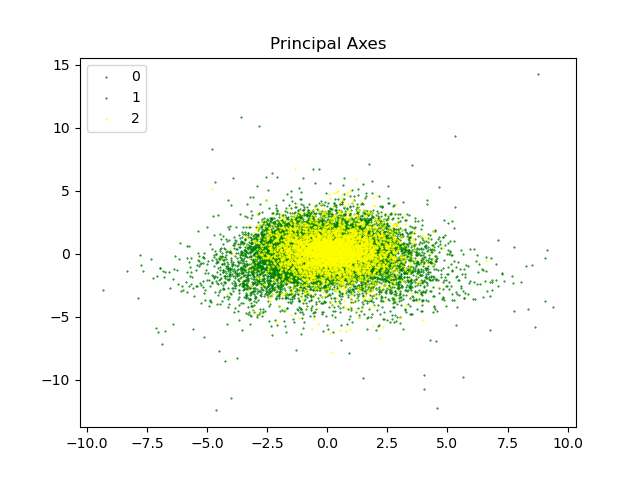

In [1397]:
# for creating a responsive plot

 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
rankA = feature_df['X_Principal0']
rankA = rankA.to_numpy()
rankB = feature_df['X_Principal1']
rankB = rankB.to_numpy()
outcomes = feature_df[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final_new"] = feature_df.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
outcomes_r = feature_df['X_Principal2']
outcome_k = outcomes["final_new"]
#outcomes_r.head(5)
outcomes_r = outcomes_r.to_numpy()
cdict = {1:'green',0:'green',2:'yellow'}
fig = plt.figure()
ax = fig.add_subplot()
for g in np.unique(outcome_k):
    ix = np.where(outcome_k == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 1)
ax.legend()
#lineStart = min(min(rankA),min(rankB))
#lineEnd = max(max(rankA),max(rankB))
#plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
#plt.xlim(lineStart, lineEnd)
#plt.ylim(lineStart, lineEnd)
plt.title("Principal Axes")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

In [1398]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
y=final_dataset_no_pca[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
y.head(5)
y.isna().sum()
y0 =  final_dataset_no_pca.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
#y0 = outcomes["final1"]
y0
y0 =y0.to_numpy()
y0
chosen_features = ["del_rank",'home_goals_mean','home_goals_mean_ln','home_goals_suf_mean', 
       'away_goals_mean', 'away_goals_mean_ln', 'away_goals_suf_mean','goals_AvB_past', 'goals_BvA_past',
       'A_victories', 'B_victories']
final_dataset_filtered = final_dataset_no_pca[chosen_features]
final_dataset_filtered = final_dataset_filtered.to_numpy()
clf.fit(final_dataset_filtered,y0)
filtered_out = clf.fit_transform(final_dataset_filtered, y0)
filtered_out.shape

(18935, 2)

In [1399]:
feature_df = pd.DataFrame(filtered_out,columns=['X_Principal0','X_Principal1'])
feature_df[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]] = final_dataset_no_pca[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
feature_df[['date', 'home_team', 'away_team','tournament']] = final_dataset_no_pca[['date', 'home_team', 'away_team','tournament']]
feature_df[['X_Principal0','X_Principal1' ,"Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]].corr(method='pearson')

X_Principal0  X_Principal1  Target_Outcome_Win  \
X_Principal0         1.000000e+00  2.109387e-15            0.441774   
X_Principal1         2.109387e-15  1.000000e+00           -0.042507   
Target_Outcome_Win   4.417740e-01 -4.250652e-02            1.000000   
Target_Outcome_Loss -4.268552e-01 -4.881438e-02           -0.601730   
Target_Outcome_Tie  -6.727901e-02  1.013946e-01           -0.537214   

                     Target_Outcome_Loss  Target_Outcome_Tie  
X_Principal0                   -0.426855           -0.067279  
X_Principal1                   -0.048814            0.101395  
Target_Outcome_Win             -0.601730           -0.537214  
Target_Outcome_Loss             1.000000           -0.350403  
Target_Outcome_Tie             -0.350403            1.000000

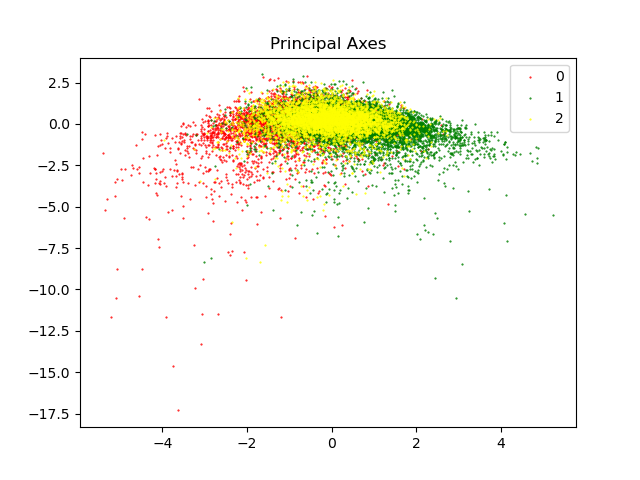

In [1400]:
# for creating a responsive plot
#%matplotlib widget
 
# importing required libraries
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
rankA = feature_df['X_Principal0']
rankA = rankA.to_numpy()
rankB = feature_df['X_Principal1']
rankB = rankB.to_numpy()
outcomes = feature_df[["Target_Outcome_Win","Target_Outcome_Loss","Target_Outcome_Tie"]]
 #historic_matches_ranked.apply(lambda row : 0 if (row.tournament == "Friendly") else 1 ,axis=1)
#One coding it .I will be confused otherwise
outcomes["final_new"] = feature_df.apply(lambda row : 1 if (row.Target_Outcome_Win == 1) else 0 if (row.Target_Outcome_Loss==1) else 2,axis=1)
#outcomes_r = feature_df['X_Principal2']
outcome_k = outcomes["final_new"]
#outcomes_r.head(5)
#outcomes_r = outcomes_r.to_numpy()
cdict = {1:'green',0:'red',2:'yellow'}
fig = plt.figure()
ax = fig.add_subplot()
for g in np.unique(outcome_k):
    ix = np.where(outcome_k == g)
    ax.scatter(rankA[ix], rankB[ix], c = cdict[g], label = g,marker='.', s = 1)
ax.legend()
#lineStart = min(min(rankA),min(rankB))
#lineEnd = max(max(rankA),max(rankB))
#plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
#plt.xlim(lineStart, lineEnd)
#plt.ylim(lineStart, lineEnd)
plt.title("Principal Axes")
plt.show()
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(rankA,rankB,outcomes_r)
#plt.show()

In [1401]:
feature_df.to_csv("LDAData.csv",index=False)

In [1402]:
a = [1,2,4]
b = [1,2,3]
c = a + b
c

[1, 2, 4, 1, 2, 3]